Here, we examine the sensitivity to a functional perturbation on a small simulated dataset

In [ ]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib, log_phi_lib
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

In [ ]:
import numpy as onp 
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 200
n_pop = 3
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

ValueError: too many values to unpack (expected 3)

# Get prior

In [ ]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

# Get VB params 

In [4]:
k_approx = 10

In [7]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [8]:
_, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                                      use_logitnormal_sticks = True)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (200, 10, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (50, 9) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (50, 9) (lb=0.0, ub=inf)


# Optimize

### Initialize with CAVI

In [10]:
vb_params_dict, cavi_init_time = \
            s_optim_lib.initialize_with_cavi(g_obs, 
                                 vb_params_paragami, 
                                 prior_params_dict, 
                                 gh_loc, gh_weights, 
                                 print_every = 20, 
                                 max_iter = 200, 
                                 seed = 1232)

Compiling cavi functions ...
CAVI compile time: 5.5sec

 running CAVI ...
iteration [20]; kl:14029.479267; elapsed: 0.3597secs
iteration [40]; kl:13826.612696; elapsed: 0.367secs
iteration [60]; kl:13807.735439; elapsed: 0.2758secs
iteration [80]; kl:13795.264374; elapsed: 0.2813secs
iteration [100]; kl:13781.287224; elapsed: 0.2784secs
iteration [120]; kl:13773.154844; elapsed: 0.277secs
iteration [140]; kl:13771.067388; elapsed: 0.2764secs
iteration [160]; kl:13770.777547; elapsed: 0.276secs
iteration [180]; kl:13770.618773; elapsed: 0.2759secs
Done. Warning, max iterations reached. 
final KL: 13770.518889
Elapsed: 199 steps in 2.92 seconds
Stick conversion time: 1.832secs


# Optimize with preconditioned LBFGS

In [11]:
vb_opt_dict, vb_opt, out, precond_objective, lbfgs_time = \
    s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                        vb_params_dict, 
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc, gh_weights)

compiling preconditioned objective ... 
done. Elasped: 32.1137
init kl: 13786.474916
iteration [20]; kl:13777.621287; elapsed: 1.570secs
iteration [24]; kl:13777.620901; elapsed: 0.440secs
lbfgs converged successfully
done. Elapsed 2.6649


# Check out the fit

Text(0.5, 1.0, 'truth')

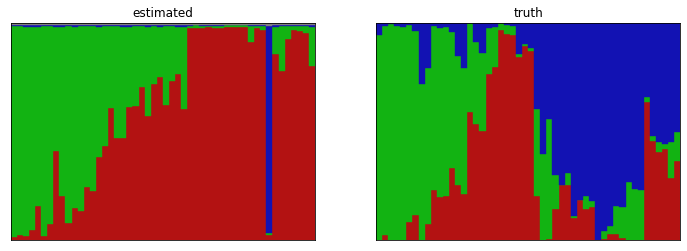

In [12]:
fig, axarr = plt.subplots(1, 2, figsize = (12, 4))

###############
# estimated 
###############
e_ind_admix, e_pop_freq = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)

_, sorted_indx = \
    plotting_utils.plot_top_clusters(e_ind_admix, axarr[0], n_top_clusters = n_pop)
axarr[0].set_title('estimated')

e_pop_freq = e_pop_freq[:, sorted_indx]

###############
# truth 
###############
# permute so that colors match (as well as possible)
perm = data_utils.find_min_perm(true_pop_allele_freq, e_pop_freq, axis = 1)

plotting_utils.plot_top_clusters(true_ind_admix_propn[:, perm], axarr[1], 
                                 n_top_clusters = n_pop);
axarr[1].set_title('truth')

# Set up linear response derivatives

In [14]:
# this is just a place holder for a null perturbation
# will set this properly later
hyper_par_objective_fun = lambda params, epsilon: 0.

In [15]:
# set up linear approximation class
epsilon0 = np.array([0.])

epsilon_sens = \
    HyperparameterSensitivityLinearApproximation(
        # doesnt matter bc we give it the hvp
        # and we will give it the hyper_par objective later
        objective_fun = None, 
        opt_par_value = vb_opt, 
        hyper_par_value0 = epsilon0, 
        obj_fun_hvp = precond_objective.hvp, 
        hyper_par_objective_fun = hyper_par_objective_fun)


NOTE: using custom hvp
Compiling hessian solver ...
Hessian solver compile time: 95.7545sec

Compiling cross hessian...
Cross-hessian compile time: 0.0485258sec

LR sensitivity time: 0.039222sec



# Compute influence function

### Define posterior quantity of interest

In [16]:
def g(vb_free_params, vb_params_paragami): 
    
    # key for random sampling. 
    # this is fixed! so all standard normal 
    # samples used in computing the posterior quantity 
    key = jax.random.PRNGKey(0)
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                       key = key,
                                                       n_samples = 100)

In [17]:
get_grad_g = jax.jacobian(g, argnums = 0)
grad_g = get_grad_g(vb_opt, vb_params_paragami)

### the influence function

In [18]:
influence_operator = influence_lib.InfluenceOperator(vb_opt, 
                           vb_params_paragami, 
                           epsilon_sens.hessian_solver,
                           prior_params_dict['dp_prior_alpha'], 
                           stick_key = 'ind_admix_params')

### worst-case perturbation

In [19]:
logit_v_grid = np.linspace(-10, 10, 200)
influence_grid = influence_operator.get_influence(logit_v_grid, grad_g)

In [20]:
worst_case_pert = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                      logit_v_grid = logit_v_grid, 
                                                      cached_influence_grid = influence_grid)

### Plot influence function

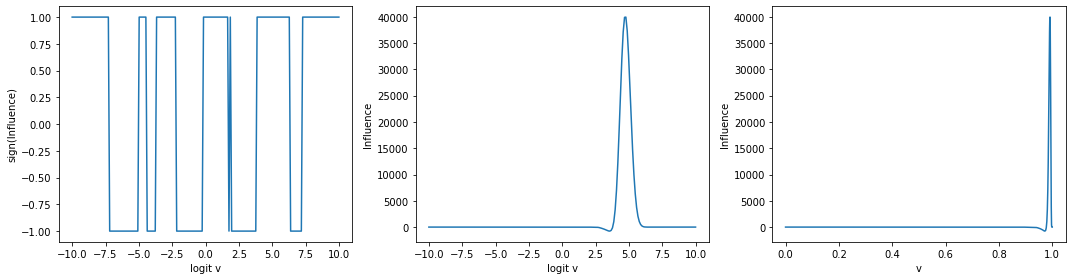

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 

ax[0].plot(worst_case_pert.logit_v_grid, np.sign(worst_case_pert.influence_grid))
ax[0].set_xlabel('logit v')
ax[0].set_ylabel('sign(Influence)')

ax[1].plot(worst_case_pert.logit_v_grid, worst_case_pert.influence_grid)
ax[1].set_xlabel('logit v')
ax[1].set_ylabel('Influence')

ax[2].plot(worst_case_pert.v_grid, worst_case_pert.influence_grid)
ax[2].set_xlabel('v')
ax[2].set_ylabel('Influence')


fig.tight_layout()

# Define prior perturbation

In [23]:
# this contains a suite of perturbations
f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami, 
                                                 prior_params_dict['dp_prior_alpha'],
                                                 gh_loc, 
                                                 gh_weights,
                                                 logit_v_grid = logit_v_grid, 
                                                 influence_grid = influence_grid, 
                                                 stick_key = 'ind_admix_params')

# name of the perturbation 
perturbation = 'worst_case'

# get class containing the necessary methods
f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)

In [25]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['dp_prior_alpha'],
                                log_phi = f_obj.log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.760788e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.941059e-01
  warnings.warn(


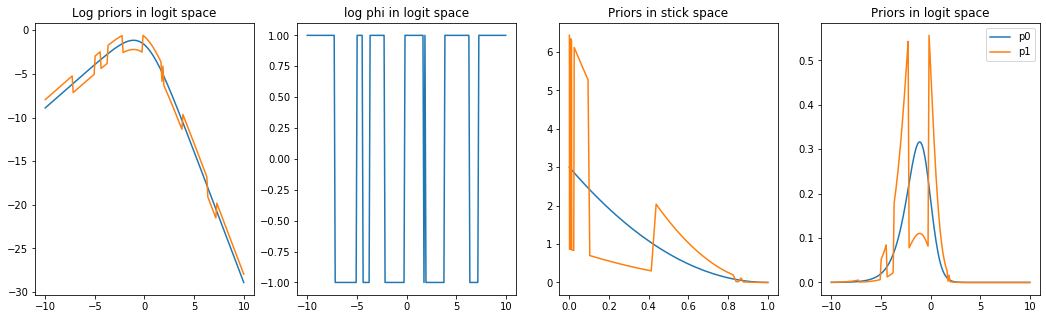

In [26]:
prior_perturbation.set_epsilon(1.0)

v_grid = sp.special.expit(logit_v_grid)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)),
            label = 'p0')
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)),
            label = 'p1')
plt.title('Priors in logit space')
plt.legend()


# Get derivative for prior perturbation

In [31]:
epsilon_sens._set_cross_hess_and_solve(f_obj.hyper_par_objective_fun)

Compiling cross hessian...
Cross-hessian compile time: 0.0823436sec

LR sensitivity time: 0.265981sec



In [32]:
epsilon = 0.1
print('Epsilon: ', epsilon)

lr_vb_free_params = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('init number of cluster: ', g(vb_opt, vb_params_paragami))
print('lr number of cluster: ', g(lr_vb_free_params, vb_params_paragami))

Epsilon:  0.1
init number of cluster:  3.4654287899110816
lr number of cluster:  3.40632520377143


In [33]:
vb_pert_pred_dict = vb_params_paragami.fold(lr_vb_free_params, free = True)

# Re-optimize

In [34]:
new_init_dict = deepcopy(vb_opt_dict)

In [36]:
vb_pert_dict, vb_opt_pert = \
    s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                                            new_init_dict,
                                            vb_params_paragami,
                                            prior_params_dict,
                                            gh_loc = gh_loc,
                                            gh_weights = gh_weights,
                                            e_log_phi = lambda means, infos : \
                                                           f_obj.e_log_phi_epsilon(means,
                                                                                       infos,
                                                                                       epsilon))[0:2]


compiling preconditioned objective ... 
done. Elasped: 26.346
init kl: 13787.899292
iteration [20]; kl:13786.382571; elapsed: 1.565secs
iteration [32]; kl:13786.380936; elapsed: 1.041secs
lbfgs converged successfully
done. Elapsed 3.1949


In [37]:
np.linalg.norm(vb_opt_pert - vb_opt)

DeviceArray(2.96085399, dtype=float64)

### compare

In [38]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot((lr_vb_free_params - vb_opt), 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


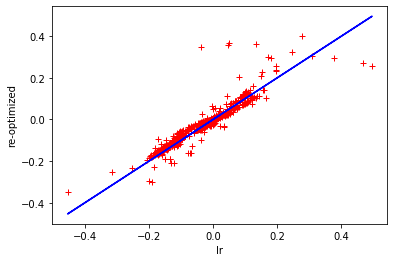

In [39]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [40]:
print('init number of cluster: ', g(vb_opt, vb_params_paragami))
print('pert number of cluster: ', g(vb_opt_pert, vb_params_paragami))
print('lr number of cluster: ', g(lr_vb_free_params, vb_params_paragami))

init number of cluster:  3.4654287899110816
pert number of cluster:  3.414950178714115
lr number of cluster:  3.40632520377143


# Fit for a range of epsilon

In [41]:
epsilon_list = np.linspace(0, 1, 8) ** 2 # Square to get more points close to 0
print(epsilon_list)

[0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [45]:
def refit_with_epsilon(epsilon, new_init_dict):
    # sets new epsilon, returns new vb optimum
    
    vb_opt = s_optim_lib.run_preconditioned_lbfgs(g_obs, 
                                         new_init_dict,
                                        vb_params_paragami,
                                        prior_params_dict,
                                        gh_loc = gh_loc,
                                        gh_weights = gh_weights,
                                        e_log_phi = lambda means, infos : \
                                                           f_obj.e_log_phi_epsilon(means, infos, epsilon))[1]
        
    return vb_opt


In [46]:
print('epsilons: ', epsilon_list)

epsilons:  [0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [47]:
vb_pert_list = []
for epsilon in epsilon_list: 
    print('\n re-optimzing with epsilon = ', epsilon)
    
    vb_pert_list.append(refit_with_epsilon(epsilon, new_init_dict))



 re-optimzing with epsilon =  0.0
compiling preconditioned objective ... 
done. Elasped: 25.8131
init kl: 13777.620901
iteration [2]; kl:13777.620854; elapsed: 0.313secs
lbfgs converged successfully
done. Elapsed 0.9022

 re-optimzing with epsilon =  0.02040816326530612
compiling preconditioned objective ... 
done. Elasped: 26.0803
init kl: 13779.718532
iteration [19]; kl:13779.653280; elapsed: 1.575secs
lbfgs converged successfully
done. Elapsed 2.1556

 re-optimzing with epsilon =  0.08163265306122448
compiling preconditioned objective ... 
done. Elasped: 25.9985
init kl: 13786.011425
iteration [20]; kl:13784.995570; elapsed: 1.525secs
iteration [29]; kl:13784.994402; elapsed: 0.801secs
lbfgs converged successfully
done. Elapsed 2.9147

 re-optimzing with epsilon =  0.18367346938775508
compiling preconditioned objective ... 
done. Elasped: 26.0105
init kl: 13796.499579
iteration [20]; kl:13791.596351; elapsed: 1.520secs
iteration [30]; kl:13791.594078; elapsed: 0.946secs
lbfgs conve

# Check free parameters

In [48]:
lr_list = []

for epsilon in epsilon_list: 
    
    # get linear response
    lr_list.append(epsilon_sens.predict_opt_par_from_hyper_par(epsilon))


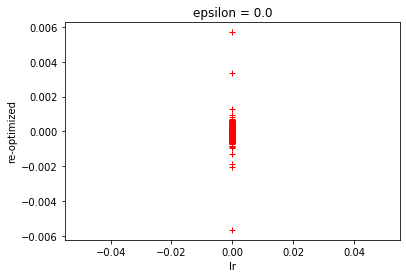

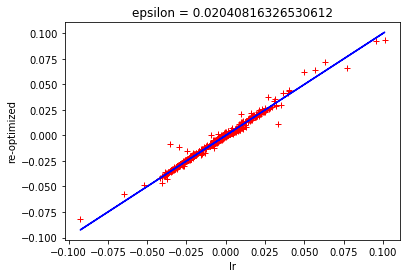

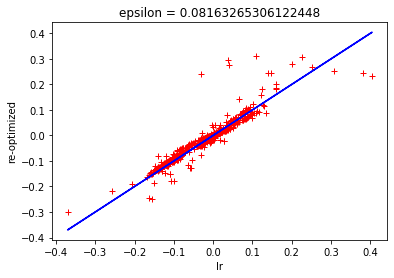

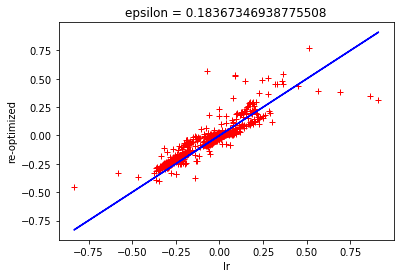

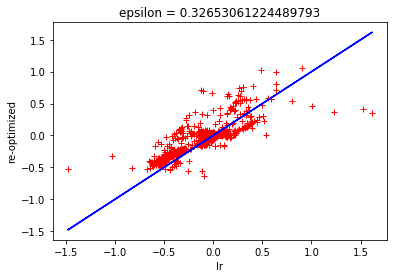

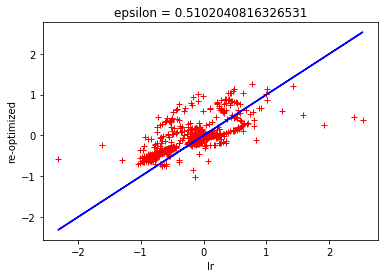

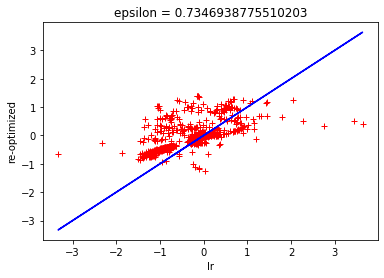

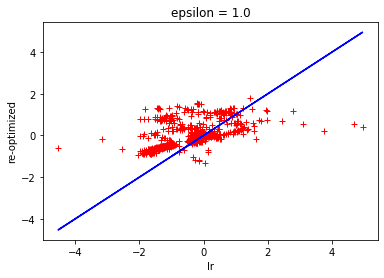

In [49]:
for i in range(len(epsilon_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('epsilon = {}'.format(epsilon_list[i]))


# Number of clusters

In [50]:
lr_e_num_clusters_vec = onp.zeros(len(epsilon_list))
refit_e_num_clusters_vec = onp.zeros(len(epsilon_list))

for i in range(len(epsilon_list)): 
        
    # get number of clusters
    refit_e_num_clusters_vec[i] = g(vb_pert_list[i], vb_params_paragami)
    lr_e_num_clusters_vec[i] = g(lr_list[i], vb_params_paragami)


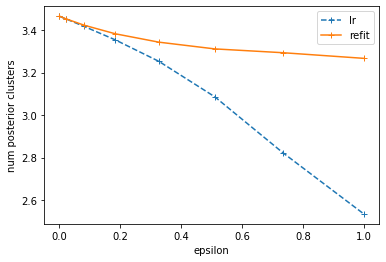

In [51]:
plt.plot(epsilon_list, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))
